### Libraries

In [ ]:
import os
if not os.path.exists('./OceanTools'):
    !git clone https://github.com/Quantitative-Environmental-Science/OceanTools.git

import sys
sys.path.append('./OceanTools')

!pip install cbsyst

from cbsyst import Csys
import numpy as np
import matplotlib.pyplot as plt

from tools import plot
from tools.helpers import get_last_values

Cloning into 'OceanTools'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 171 (delta 34), reused 27 (delta 19), pack-reused 123
Receiving objects: 100% (171/171), 525.27 KiB | 16.41 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 56.4 MB/s eta 0:00:00


# Scenario 1: Global Warming

Increasing pCO<sub>2</sub> in the atmosphere leads to an increase in surface temperature. In this scenario, you will explore how rising surface temperatures might alter the amount of carbon taken up by the ocean.

We can simulate this in the model by including a **climate sensitivity** term, which describes the increase in surface temperature as a function of doubling pCO<sub>2</sub> in the atmosphere:

$$
T_i = T_i^0 + \gamma \left(\frac{pCO_2}{pCO_2^0} - 1\right)
$$

Where $T_i$ is the atmospheric temperature above each surface box, $T_i^0$ is the initial temperature of the atmosphere above each box, $\gamma$ is the *sensitivity* of atmospheric temperature to changes in pCO<sub>2</sub> in degrees per doubling of pCO<sub>2</sub>, and pCO<sub>2</sub><sup>0</sup> is the initial concentration of CO<sub>2</sub> in the atmosphere.

Include the sensitivity of surface temperature to pCO<sub>2</sub> in your model. Use values of $pCO_2^0 = 418$ ppm, $\gamma = 2.5$ degrees, and keep the same initial atmospheric temperatures (`T_atmos`) for the `lolat` and `hilat` boxes. Use your modified model to address the following questions:

1.  Conduct a CO<sub>2</sub> release experiment, where $\mathrm{8~GtC~yr^{-1}}$ is emitted into the atmosphere for 200 years. Run the model to steady-state, and examine the evolution of the temperature and carbon chemistry of the surface ocean and atmosphere compared to the original model. Discuss the patterns you observe.
2. Repeat your release experiment with $\gamma = 5$. How does this alter the maximum and steady-state pCO<sub>2</sub> in the modified model? What can you infer from this about the relationship between atmospheric temperature sensitivity and equilibrium pCO<sub>2</sub>?
3. What additional factors might influence how these patterns manifest in the real ocean? How might you test these additional factors in the model?


## Model Set-Up

###initial conditions


In [ ]:
# global variables
V_ocean = 1.34e18  # volume of the ocean in m3
SA_ocean = 358e12  # surface area of the ocean in m2
fSA_hilat = 0.15  # fraction of ocean surface area in 'high latitude' box

# variables used to calculate Q
Q_alpha = 1e-4
Q_beta = 7e-4
Q_k = 8.3e17

# salinity balance - the total amount of salt added or removed to the surface boxes
Fw = 0.1  # low latitude evaporation - precipitation in units of m yr-1
Sref = 35  # reference salinity in units of g kg-1
E = Fw * SA_ocean * (1 - fSA_hilat) * Sref  # amount of salt removed from the low latitude box,  g kg-1 yr-1, ~ kg m-3 yr-1

# climate sensitivity values
gamma = 2.5  # climate sensitivity term describing the increase in temperature we expect from a doubling of pCO2, deg Celcius
pCO2_0 = 418 #  concentration of CO2 in the initial atmosphere, ppm

In [ ]:
# NOTE: Initial DIC, TA, PO4 and pCO2 values are set to steady state values from the unmodified model.

init_hilat = {
    'name': 'hilat',
    'depth': 200,  # box depth, m
    'SA': SA_ocean * fSA_hilat,  # box surface area, m2
    'T': 3.897678,  # initial water temperature, Celcius
    'S': 34.37786,  # initial salinity
    'T_atmos': 0.,  # air temperature, Celcius
    'tau_M': 100.,  # timescale of surface-deep mixing, yr
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': -E,  # salt added due to evaporation - precipitation, kg m-3 yr-1
    'tau_CO2': 2.,  # timescale of CO2 exchange, yr
    'DIC': 2.02837,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': 2.22116,  # Total Alkalinity, mol m-3
    'tau_PO4': 3.,  # phosphate half life, yr at initial f_CaCO3
    'PO4': 8.8995e-5,  # Phosphate conc, mol m-3
    'f_CaCO3': 0.2,  # fraction of organic matter export that produces CaCO3 at starting [CO3]
}
init_hilat['V'] = init_hilat['SA'] *  init_hilat['depth']  # box volume, m3

init_lolat = {
    'name': 'lolat',
    'depth': 100,  # box depth, m
    'SA': SA_ocean * (1 - fSA_hilat),  # box surface area, m2
    'T': 23.60040,  # initial water temperature, Celcius
    'S': 35.37898,  # initial salinity
    'T_atmos': 25.,  # air temperature, Celcius
    'tau_M': 250.,  # timescale of surface-deep mixing, yr
    'tau_T': 2.,  # timescale of temperature exchange with atmosphere, yr
    'E': E,  # salinity balance, PSU m3 yr-1
    'tau_CO2': 2.,  # timescale of CO2 exchange, yr
    'DIC': 1.99405,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': 2.21883,  # Total Alkalinity, mol m-3
    'tau_PO4': 2.,  # phosphate half life, yr at initial f_CaCO3
    'PO4': 1.6541e-4,  # Phosphate conc, mol m-3
    'f_CaCO3': 0.3,  # fraction of organic matter export that produces CaCO3 at starting [CO3]
}
init_lolat['V'] = init_lolat['SA'] *  init_lolat['depth']  # box volume, m3

init_deep = {
    'name': 'deep',
    'V': V_ocean - init_lolat['V'] - init_hilat['V'],  # box volume, m3
    'T': 5.483637,  # initial water temperature, Celcius
    'S': 34.47283,  # initial salinity
    'DIC': 2.32712,  # Dissolved Inorganic Carbon concentration, mol m-3
    'TA': 2.31640,  # Total Alkalinity, mol m-3
    'PO4': 2.30515e-3,  # Phosphate conc, mol m-3
}

init_atmos = {
    'name': 'atmos',
    'mass': 5.132e18,  # kg
    'moles_air': 1.736e20,  # moles
    'moles_CO2': 872e15 / 12,  # moles
    'GtC_emissions': 0.0  # annual emissions of CO2 into the atmosphere, GtC
}
init_atmos['pCO2'] = init_atmos['moles_CO2'] / init_atmos['moles_air'] * 1e6

### Original Model Code

The function below contains the 'baseline' model as a comparison point for the new model. Future models are changed versions of this.

In [ ]:
def original_model(lolat, hilat, deep, atmos, tmax, dt):

    # create the time scale for the model
    time = np.arange(0, tmax + dt, dt)

    # identify which variables will change with time
    model_vars = ['T', 'S', 'DIC', 'TA', 'PO4']
    atmos_model_vars = ['moles_CO2', 'pCO2']

    # create copies of the input dictionaries so we don't modify the originals
    lolat = lolat.copy()
    hilat = hilat.copy()
    deep = deep.copy()
    atmos = atmos.copy()

    # turn all time-evolving variables into arrays containing the start values
    for box in [lolat, hilat, deep]:
        for k in model_vars:
            box[k] = np.full(time.shape, box[k])
    for k in atmos_model_vars:
        atmos[k] = np.full(time.shape, atmos[k])
    if isinstance(atmos['GtC_emissions'], (int, float)):
        atmos['GtC_emissions'] = np.full(time.shape, atmos['GtC_emissions'])

    # calculate initial surface carbon chemistry in the surface boxes using Csys, and store a few key variables - CO2, pH, pCO2 and K0
    for box in [lolat, hilat]:
        csys = Csys(
            TA=box['TA'], DIC=box['DIC'],
            T_in=box['T'], S_in=box['S'],
            unit='mmol'  # we specify mmol here because mol m-3 is the same as mmol L-1, and Csys works in L-1
            )
        box['CO2'] = csys.CO2
        box['pH'] = csys.pHtot
        box['pCO2'] = csys.pCO2
        box['K0'] = csys.Ks.K0

    # Create a dictionary to keep track of the fluxes calculated at each step
    fluxes = {}

    for i in range(1, time.size):
        last = i - 1  # index of last model step

        # calculate circulation flux, Q
        dT = lolat['T'][last] - hilat['T'][last]
        dS = lolat['S'][last] - hilat['S'][last]
        Q = Q_k * (Q_alpha * dT - Q_beta * dS)

        # calculate mixing fluxes for model variables
        for var in model_vars:
            fluxes[f'Q_{var}_deep'] = Q * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_hilat'] = Q * (lolat[var][last] - hilat[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_lolat'] = Q * (deep[var][last] - lolat[var][last]) * dt  # mol dt-1

            fluxes[f'vmix_{var}_hilat'] = hilat['V'] / hilat['tau_M'] * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'vmix_{var}_lolat'] = lolat['V'] / lolat['tau_M'] * (lolat[var][last] - deep[var][last]) * dt  # mol dt-1

        # calculate surface-specific fluxes
        for box in [hilat, lolat]:
            boxname = box['name']
            # temperature exchange with atmosphere
            fluxes[f'dT_{boxname}'] = box['V'] / box['tau_T'] * (box['T_atmos'] - box['T'][last]) * dt  # mol dt-1
            # CO2 exchange with atmosphere
            fluxes[f'dCO2_{boxname}'] = box['V'] / box['tau_CO2'] * (box['CO2'][last] - 1e-3 * atmos['pCO2'][last] * box['K0'][last]) * dt  # mol dt-1
            # organic matter production
            fluxes[f'export_PO4_{boxname}'] = box['PO4'][last] * box['V'] / box['tau_PO4'] * dt  # mol PO4 dt-1
            # DIC export by productivity :                                  redfield + calcification
            fluxes[f'export_DIC_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (106 + 106 * box['f_CaCO3'])  # mol DIC dt-1
            # TA export by productivity :                                  redfield + calcification
            fluxes[f'export_TA_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (-18 + 2 * 106 * box['f_CaCO3'])  # mol TA dt-1

        fluxes['dCO2_emissions'] = atmos['GtC_emissions'][last] * 1e15 / 12 * dt  # mol dt-1

        # update deep box
        for var in model_vars:
            if var in ['T', 'S']:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat']
                ) / deep['V']
            else:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat'] + fluxes[f'export_{var}_hilat'] + fluxes[f'export_{var}_lolat']
                ) / deep['V']

        # update surface boxes
        for box in [hilat, lolat]:
            boxname = box['name']
            box['S'][i] = box['S'][last] + (fluxes[f'Q_S_{boxname}'] - fluxes[f'vmix_S_{boxname}'] + box['E'] * dt) / box['V']
            box['T'][i] = box['T'][last] + (fluxes[f'Q_T_{boxname}'] - fluxes[f'vmix_T_{boxname}'] + fluxes[f'dT_{boxname}']) / box['V']
            box['DIC'][i] = box['DIC'][last] + (fluxes[f'Q_DIC_{boxname}'] - fluxes[f'vmix_DIC_{boxname}'] - fluxes[f'dCO2_{boxname}'] - fluxes[f'export_DIC_{boxname}']) / box['V']
            box['TA'][i] = box['TA'][last] + (fluxes[f'Q_TA_{boxname}'] - fluxes[f'vmix_TA_{boxname}'] - fluxes[f'export_TA_{boxname}']) / box['V']
            box['PO4'][i] = box['PO4'][last] + (fluxes[f'Q_PO4_{boxname}'] - fluxes[f'vmix_PO4_{boxname}'] - fluxes[f'export_PO4_{boxname}']) / box['V']

            # update carbon speciation
            csys = Csys(
                TA=box['TA'][i], DIC=box['DIC'][i],
                T_in=box['T'][i], S_in=box['S'][i],
                unit='mmol'
                )
            box['CO2'][i] = csys.CO2
            box['pCO2'][i] = csys.pCO2
            box['pH'][i] = csys.pHtot
            box['K0'][i] = csys.Ks.K0

        # update atmosphere
        atmos['moles_CO2'][i] = atmos['moles_CO2'][last] + fluxes['dCO2_hilat'] + fluxes['dCO2_lolat'] + fluxes['dCO2_emissions']
        atmos['pCO2'][i] = 1e6 * atmos['moles_CO2'][i] / atmos['moles_air']

    return time, lolat, hilat, deep, atmos

In [ ]:
# perform baseline model run
otime, ololat, ohilat, odeep, oatmos = original_model(init_lolat, init_hilat, init_deep, init_atmos, 2000, 0.5)

lolat
  520.01
hilat
  265.96
atmos
  418.04


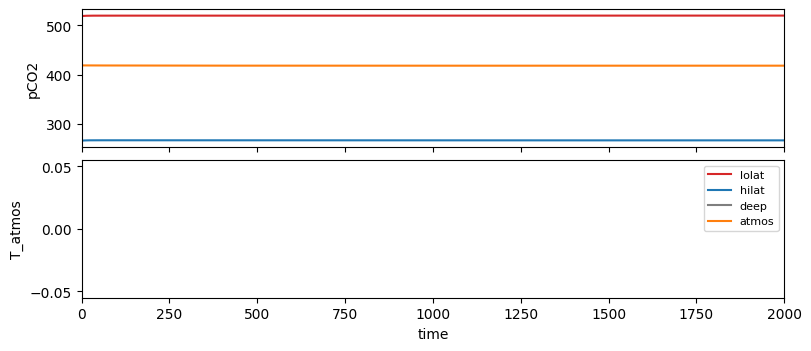

In [ ]:
vars = ['pCO2', 'T_atmos']
plot.boxes(otime, vars, ololat, ohilat, odeep, oatmos)

for k, v in get_last_values(ololat, ohilat, oatmos).items():
    print(k)
    for var in vars:
        if var in v:
            print(f"  {v[var]:.2f}")

### $\gamma$ = 2.5 model (steady state)

In [ ]:
def warming_model(lolat, hilat, deep, atmos, tmax, dt, Gamma):

    # create the time scale for the model
    time = np.arange(0, tmax + dt, dt)

    # identify which variables will change with time
    model_vars = ['T', 'S', 'DIC', 'TA', 'PO4']
    atmos_model_vars = ['moles_CO2', 'pCO2']
    track_vars = ['T_atmos']

    # create copies of the input dictionaries so we don't modify the originals
    lolat = lolat.copy()
    hilat = hilat.copy()
    deep = deep.copy()
    atmos = atmos.copy()

    # turn all time-evolving variables into arrays containing the start values
    for box in [lolat, hilat, deep]:
        for k in model_vars:
            box[k] = np.full(time.shape, box[k])
        for k in track_vars:
            if k in box:
                box[k] = np.full(time.shape, box[k])
    for k in atmos_model_vars:
        atmos[k] = np.full(time.shape, atmos[k])
    if isinstance(atmos['GtC_emissions'], (int, float)):
        atmos['GtC_emissions'] = np.full(time.shape, atmos['GtC_emissions'])

    # calculate initial surface carbon chemistry in the surface boxes using Csys, and store a few key variables - CO2, pH, pCO2 and K0
    for box in [lolat, hilat]:
        csys = Csys(
            TA=box['TA'], DIC=box['DIC'],
            T_in=box['T'], S_in=box['S'],
            unit='mmol'  # we specify mmol here because mol m-3 is the same as mmol L-1, and Csys works in L-1
            )
        box['CO2'] = csys.CO2
        box['pH'] = csys.pHtot
        box['pCO2'] = csys.pCO2
        box['K0'] = csys.Ks.K0

        # box['T_atmos'] = box['T_atmos'] + gamma * (box['pCO2'] / pCO2_0 - 1)

    # Create a dictionary to keep track of the fluxes calculated at each step
    fluxes = {}

    for i in range(1, time.size):
        last = i - 1  # index of last model step

        # calculate circulation flux, Q
        dT = lolat['T'][last] - hilat['T'][last]
        dS = lolat['S'][last] - hilat['S'][last]
        Q = Q_k * (Q_alpha * dT - Q_beta * dS)

        # calculate mixing fluxes for model variables
        for var in model_vars:
            fluxes[f'Q_{var}_deep'] = Q * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_hilat'] = Q * (lolat[var][last] - hilat[var][last]) * dt  # mol dt-1
            fluxes[f'Q_{var}_lolat'] = Q * (deep[var][last] - lolat[var][last]) * dt  # mol dt-1

            fluxes[f'vmix_{var}_hilat'] = hilat['V'] / hilat['tau_M'] * (hilat[var][last] - deep[var][last]) * dt  # mol dt-1
            fluxes[f'vmix_{var}_lolat'] = lolat['V'] / lolat['tau_M'] * (lolat[var][last] - deep[var][last]) * dt  # mol dt-1

        # calculate surface-specific fluxes
        for box in [hilat, lolat]:
            boxname = box['name']
            # temperature exchange with atmosphere
            fluxes[f'dT_{boxname}'] = box['V'] / box['tau_T'] * (box['T_atmos'][last] - box['T'][last]) * dt  # mol dt-1
            # CO2 exchange with atmosphere
            fluxes[f'dCO2_{boxname}'] = box['V'] / box['tau_CO2'] * (box['CO2'][last] - 1e-3 * atmos['pCO2'][last] * box['K0'][last]) * dt  # mol dt-1
            # organic matter production
            fluxes[f'export_PO4_{boxname}'] = box['PO4'][last] * box['V'] / box['tau_PO4'] * dt  # mol PO4 dt-1
            # DIC export by productivity :                                  redfield + calcification
            fluxes[f'export_DIC_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (106 + 106 * box['f_CaCO3'])  # mol DIC dt-1
            # TA export by productivity :                                  redfield + calcification
            fluxes[f'export_TA_{boxname}'] = fluxes[f'export_PO4_{boxname}'] * (-18 + 2 * 106 * box['f_CaCO3'])  # mol TA dt-1

        fluxes['dCO2_emissions'] = atmos['GtC_emissions'][last] * 1e15 / 12 * dt  # mol dt-1

        # update deep box
        for var in model_vars:
            if var in ['T', 'S']:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat']
                ) / deep['V']
            else:
                deep[var][i] = deep[var][last] + (
                    fluxes[f'Q_{var}_deep'] + fluxes[f'vmix_{var}_hilat'] + fluxes[f'vmix_{var}_lolat'] + fluxes[f'export_{var}_hilat'] + fluxes[f'export_{var}_lolat']
                ) / deep['V']

        # update surface boxes
        for box in [hilat, lolat]:
            boxname = box['name']
            box['S'][i] = box['S'][last] + (fluxes[f'Q_S_{boxname}'] - fluxes[f'vmix_S_{boxname}'] + box['E'] * dt) / box['V']
            box['T'][i] = box['T'][last] + (fluxes[f'Q_T_{boxname}'] - fluxes[f'vmix_T_{boxname}'] + fluxes[f'dT_{boxname}']) / box['V']
            box['DIC'][i] = box['DIC'][last] + (fluxes[f'Q_DIC_{boxname}'] - fluxes[f'vmix_DIC_{boxname}'] - fluxes[f'dCO2_{boxname}'] - fluxes[f'export_DIC_{boxname}']) / box['V']
            box['TA'][i] = box['TA'][last] + (fluxes[f'Q_TA_{boxname}'] - fluxes[f'vmix_TA_{boxname}'] - fluxes[f'export_TA_{boxname}']) / box['V']
            box['PO4'][i] = box['PO4'][last] + (fluxes[f'Q_PO4_{boxname}'] - fluxes[f'vmix_PO4_{boxname}'] - fluxes[f'export_PO4_{boxname}']) / box['V']

            # update carbon speciation
            csys = Csys(
                TA=box['TA'][i], DIC=box['DIC'][i],
                T_in=box['T'][i], S_in=box['S'][i],
                unit='mmol'
                )
            box['CO2'][i] = csys.CO2
            box['pCO2'][i] = csys.pCO2
            box['pH'][i] = csys.pHtot
            box['K0'][i] = csys.Ks.K0

            box['T_atmos'][i] = box['T_atmos'][0] + Gamma * ((box['pCO2'][i] / pCO2_0) - 1)

        # update atmosphere
        atmos['moles_CO2'][i] = atmos['moles_CO2'][last] + fluxes['dCO2_hilat'] + fluxes['dCO2_lolat'] + fluxes['dCO2_emissions']
        atmos['pCO2'][i] = 1e6 * atmos['moles_CO2'][i] / atmos['moles_air']

    return time, lolat, hilat, deep, atmos

In [ ]:
ntime, nlolat, nhilat, ndeep, natmos = warming_model(init_lolat, init_hilat, init_deep, init_atmos, 2000, 0.5, 2.5)
n5time, n5lolat, n5hilat, n5deep, n5atmos = warming_model(init_lolat, init_hilat, init_deep, init_atmos, 2000, 0.5, 5)

lolat
  pCO2: 534.48
  T_atmos: 25.70
hilat
  pCO2: 261.61
  T_atmos: -0.94
atmos
  pCO2: 423.56


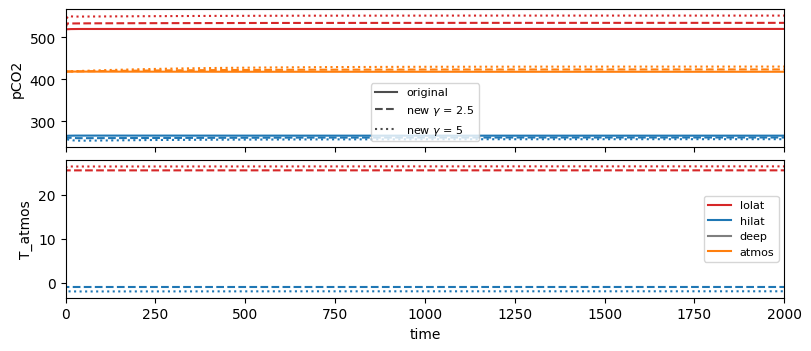

In [ ]:
# plot and compare the steady-state values
# NOTE: The models should be very similar at steady state if everything is working correctly

vars = ['pCO2', 'T_atmos']

fig, axs = plot.boxes(otime, vars, ololat, ohilat, odeep, oatmos)
plot.boxes(ntime, vars, nlolat, nhilat, ndeep, natmos, axs=axs, label='new $\gamma$ = 2.5', ls='--')
plot.boxes(n5time, vars, n5lolat, n5hilat, n5deep, n5atmos, axs=axs, label='new $\gamma$ = 5', ls=':')

for k, v in get_last_values(nlolat, nhilat, natmos).items():
    print(k)
    for var in vars:
        if var in v:
            print(f"  {var}: {v[var]:.2f}")

### $\text{CO}_2$ EMISSIONS

In [ ]:
new_init_lolat = init_lolat.copy()
new_init_hilat = init_hilat.copy()
new_init_deep = init_deep.copy()

In [ ]:
# create a new time axis for the model containing 3000 years with a 0.5 year time step
tmax = 3000  # how many years to simulate (yr)
dt = 0.5  # the time step of the simulation (yr)
time = np.arange(0, tmax + dt, dt)  # the time axis for the model

# create an array containing GtC_emissions that contains zeros except between 800-1000 years, where 8 GtC are emitted each year.
emit_atmos = init_atmos.copy()  # create a copy of the original atmosphere input dictionary
emit_atmos['GtC_emissions'] = np.zeros(time.shape)  # creat an array to hold the emission scenario
emit_atmos['GtC_emissions'][(time > 400) & (time <= 600)] = 8.0  # set emissions to 8 GtC per year between 800-1000 years


# run the model using this emission scenario, and create the required plot
onew_time, onew_lolat, onew_hilat, onew_deep, onew_atmos = original_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5)
new_time, new_lolat, new_hilat, new_deep, new_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 2.5)

new5_time, new5_lolat, new5_hilat, new5_deep, new5_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 2000, 0.5, 5)

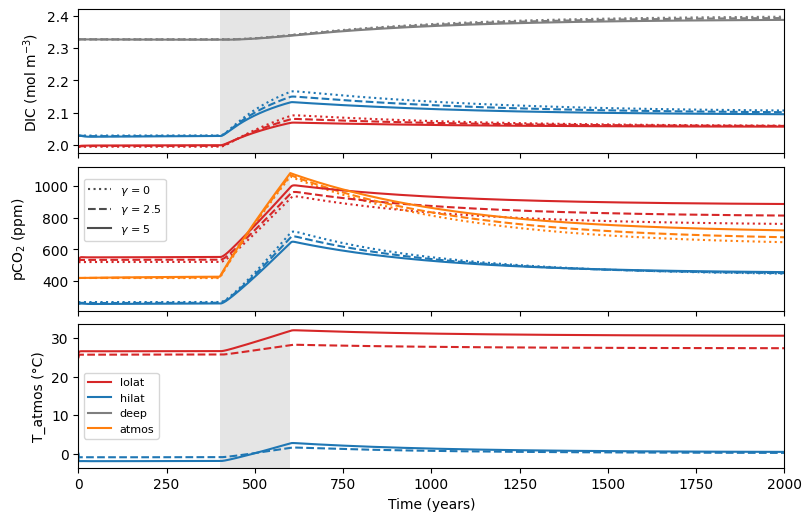

In [ ]:
vars = ['DIC', 'pCO2', 'T_atmos']

fig, axs = plot.boxes(onew_time, vars, onew_lolat, onew_hilat, onew_deep, onew_atmos, label = '$\gamma$ = 0', ls = ':')
plot.boxes(new_time, vars, new_lolat, new_hilat, new_deep, new_atmos, axs=axs, label='$\gamma$ = 2.5', ls='--')
plot.boxes(new5_time, vars, new5_lolat, new5_hilat, new5_deep, new5_atmos, axs=axs, label='$\gamma$ = 5', ls='-')

# Set custom axes labels
axs[0].set_ylabel('DIC (mol m$^{-3}$)')

axs[1].set_ylabel('pCO$_2$ (ppm)')

axs[2].set_xlabel('Time (years)')
axs[2].set_ylabel('T_atmos (°C)')

axs[1].legend(loc = 'center left', fontsize = 8, bbox_to_anchor = (0,0.7))
axs[2].legend(loc = 'center left', fontsize = 8, bbox_to_anchor = (0,0.43))

for ax in axs:
    ax.axvspan(*(400, 600), color='k', alpha=0.1, lw=0, zorder=-1)

# from google.colab import files
# plt.savefig("Lab Report 6_2.png",dpi=300)
# files.download("Lab Report 6_2.png")

In [ ]:
for k, v in get_last_values(new5_lolat, new5_hilat, new5_deep, new5_atmos).items():
    print(k)
    for var in vars:
        if var in v:
            print(f"  {var}: {v[var]:.2f}")

lolat
  DIC: 2.06
  TA: 2.22
  pCO2: 887.19
  T_atmos: 30.61
hilat
  DIC: 2.10
  TA: 2.22
  pCO2: 455.78
  T_atmos: 0.45
deep
  DIC: 2.39
  TA: 2.32
atmos
  pCO2: 720.23


### $T_{atmos}$ and $pCO_2$ vs $\gamma$ plot

In [ ]:
# new1_time, new1_lolat, new1_hilat, new1_deep, new1_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 1)
# new2_time, new2_lolat, new2_hilat, new2_deep, new2_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 2)
# new3_time, new3_lolat, new3_hilat, new3_deep, new3_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 3)
# new4_time, new4_lolat, new4_hilat, new4_deep, new4_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 4)
# new5_time, new5_lolat, new5_hilat, new5_deep, new5_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 5)
# new6_time, new6_lolat, new6_hilat, new6_deep, new6_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 6)
# new7_time, new7_lolat, new7_hilat, new7_deep, new7_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 7)
# new8_time, new8_lolat, new8_hilat, new8_deep, new8_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 8)
# new9_time, new9_lolat, new9_hilat, new9_deep, new9_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 9)
# new10_time, new10_lolat, new10_hilat, new10_deep, new10_atmos = warming_model(new_init_lolat, new_init_hilat, new_init_deep, emit_atmos, 3000, 0.5, 10)

NameError: ignored

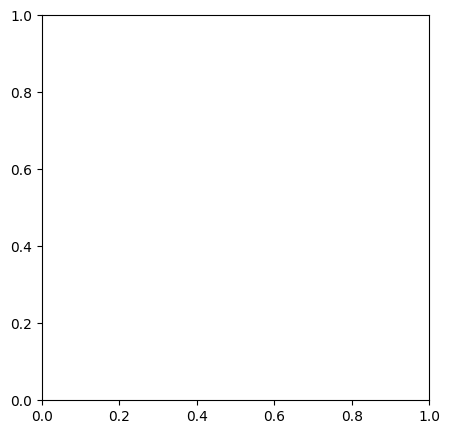

In [ ]:
fig, ax1 = plt.subplots(figsize=(5, 5))

gammas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
data = {
    gamma: {"lolat": {"T_atmos": None, "pCO2": None}, "hilat": {"T_atmos": None, "pCO2": None}}
    for gamma in gammas
}

datasets = [
    (new1_lolat, new1_hilat, 1),
    (new2_lolat, new2_hilat, 2),
    (new3_lolat, new3_hilat, 3),
    (new4_lolat, new4_hilat, 4),
    (new5_lolat, new5_hilat, 5),
    (new6_lolat, new6_hilat, 6),
    (new7_lolat, new7_hilat, 7),
    (new8_lolat, new8_hilat, 8),
    (new9_lolat, new9_hilat, 9),
    (new10_lolat, new10_hilat, 10),
]

for lolat, hilat, gamma in datasets:
    data[gamma]["lolat"]["T_atmos"] = lolat["T_atmos"][-1]
    data[gamma]["hilat"]["T_atmos"] = hilat["T_atmos"][-1]
    data[gamma]["lolat"]["pCO2"] = lolat["pCO2"][-1]
    data[gamma]["hilat"]["pCO2"] = hilat["pCO2"][-1]

ax1.set_xlabel('$\gamma \;(\degree C)$', fontsize = 11)

# Plot T_atmos
ax1.plot(gammas, [data[gamma]["lolat"]["T_atmos"] for gamma in gammas], label="T_atmos (lolat)", color = 'C3')
ax1.plot(gammas, [data[gamma]["hilat"]["T_atmos"] for gamma in gammas], label="T_atmos (hilat)", color = 'C0')
ax1.set_xlim(1, 10)
ax1.set_ylabel("T_atmos ($\degree C$)", fontsize = 11)
ax1.legend(loc="upper left")

# Create a secondary y-axis and plot pCO2
ax2 = ax1.twinx()
ax2.plot(gammas, [data[gamma]["lolat"]["pCO2"] for gamma in gammas], label="pCO2 (lolat)", color = 'C3', linestyle="--")
ax2.plot(gammas, [data[gamma]["hilat"]["pCO2"] for gamma in gammas], label="pCO2 (hilat)", color = 'C0', linestyle="--")
ax2.set_ylabel("pCO2 (ppm)", fontsize = 11)
ax2.legend(loc="upper left", bbox_to_anchor = (0,0.87))

plt.tight_layout()
# from google.colab import files
# plt.savefig("Lab Report 6_4.png",dpi=300)
# files.download("Lab Report 6_4.png")

### Change in pCO2, modified - minus original

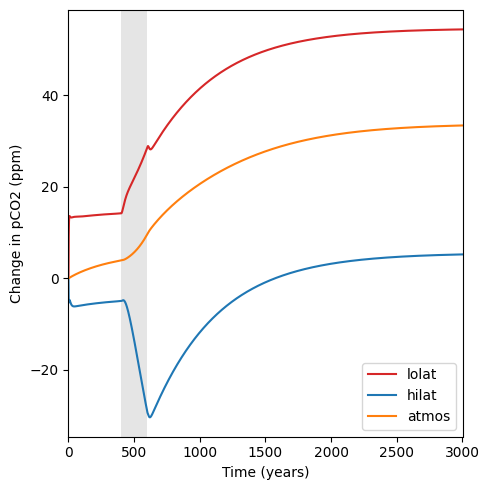

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

# Calculate the change in pCO2 for each box
change_lolat_pCO2 = new_lolat['pCO2'] - onew_lolat['pCO2']
change_hilat_pCO2 = new_hilat['pCO2'] - onew_hilat['pCO2']
change_atmos_pCO2 = new_atmos['pCO2'] - onew_atmos['pCO2']

# Plot the change in pCO2
ax.plot(new_time, change_lolat_pCO2, label='lolat', color='C3')
ax.plot(new_time, change_hilat_pCO2, label='hilat', color='C0')
ax.plot(new_time, change_atmos_pCO2, label='atmos', color='C1')

# shade emission period
ax.axvspan(*(400, 600), color='k', alpha=0.1, lw=0, zorder=-1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Change in pCO2 (ppm)')
ax.legend(loc='best')
ax.set_xlim(0,3000)

plt.tight_layout()

# from google.colab import files
# plt.savefig("Lab Report 6_3.png",dpi=300)
# files.download("Lab Report 6_3.png")

### Introdcutory Figure - pCO2 vs initial temperature

In [ ]:
# Define a range of temperatures
temperatures = np.linspace(-10, 40, 100)

# Define some example parameters for seawater
salinity = 35

# Define DIC and TA values for hilat and lolat
params = [
    {"label": "hilat", "DIC": 2028.37, "TA": 2221.16},
    {"label": "lolat", "DIC": 1994.05, "TA": 2218.83}
]

fig, axs = plt.subplots(figsize = (5,4))

# Calculate pCO2 for each temperature and plot the lines
for param in params:
    pco2_values = []
    for temp in temperatures:
        csys = Csys(T_in=temp, S_in=salinity, TA=param["TA"], DIC=param["DIC"])  #T_in = T_atmos initial only
        pco2_values.append(csys.pCO2)  # Convert from µatm to ppm

    axs.plot(pco2_values, temperatures, label=param["label"])


# Add arrows and labels
arrow_start_points = [0, 25]
curves = plt.gca().lines
for y, curve in zip(arrow_start_points, curves):
    x = curve.get_xdata()[np.argmin(np.abs(curve.get_ydata() - y))]
    plt.arrow(0, y, x, 0, head_width=1, head_length=20, fc='k', ec='k', length_includes_head=True)
    plt.text(x - 122, y + 2, '{:.0f} ppm'.format(x), ha='center', va='bottom')



# Add a dotted vertical line for x=0
axs.axvline(0, color='black', linestyle='dotted')

axs.set_ylabel('Temperature (°C)')
axs.set_xlabel('pCO2 (ppm)')
axs.set_ylim(-10,40)
plt.tight_layout()
plt.legend()


# from google.colab import files
# plt.savefig("Lab Report 6_1.png",dpi=300)
# files.download("Lab Report 6_1.png")

In [ ]:
# Define a range of temperatures
temperatures = np.linspace(-10, 40, 100)

# Define some example parameters for seawater
salinity = 35

# Define DIC and TA values for hilat and lolat
params = [
    {"label": "hilat", "DIC": 2028.37, "TA": 2221.16},
    {"label": "lolat", "DIC": 1994.05, "TA": 2218.83}
]

fig, axs = plt.subplots(figsize = (5,4))

# Calculate pCO2 for each temperature and plot the lines
for param in params:
    pco2_values = []
    for temp in temperatures:
        csys = Csys(T_in=temp, S_in=salinity, TA=param["TA"], DIC=param["DIC"])  #T_in = T_atmos initial only
        pco2_values.append(csys.pCO2)  # Convert from µatm to ppm

    axs.plot(temperatures, pco2_values, label=param["label"])

# Add arrows and labels
arrow_start_points = [0, 25]
curves = plt.gca().lines
for x, curve in zip(arrow_start_points, curves):
    y = curve.get_ydata()[np.argmin(np.abs(curve.get_xdata() - x))]
    plt.arrow(x, 0, 0, y, head_width=1, head_length=20, fc='k', ec='k', length_includes_head=True)
    plt.text(x + 1, y / 2, '{:.1f} ppm'.format(y), ha='left', va='center')

# Add a dotted horizontal line for y=0
axs.axhline(0, color='black', linestyle='dotted')

axs.set_xlabel('Temperature (°C)')
axs.set_ylabel('pCO2 (ppm)')
axs.set_xlim(-10,40)
plt.tight_layout()
plt.legend()